In [80]:
import cv2, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

In [81]:
ORIG_DIR = Path("./dataset/autos")        # donde están auto001.jpeg, ...
PROC_DIR = Path("./dataset/autos_proc")   # guardaremos las imágenes B/N
BITS_DIR = Path("./dataset/autos_bits")   # guardaremos .npy con los bits
PROC_DIR.mkdir(parents=True, exist_ok=True)
BITS_DIR.mkdir(parents=True, exist_ok=True)

In [82]:
def extract_plate_and_bits(path, debug=False):
    """
    Devuelve:
        bn      : imagen 2‑D uint8 (45×30) en blanco‑negro (0/255)
        bits    : numpy array uint8 (1350,) con 0/1
    """
    img = cv2.imread(str(path))
    if img is None:
        raise RuntimeError(f"Imagen no encontrada: {path}")

    hsv  = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (15, 100, 100), (30, 255, 255))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                            cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plate, possible_plate, max_area = None, None, 0

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        r, area = w / float(h), w * h
        if 1.8 < r < 3.2 and w > 40:          # proporciones de placa ideales
            plate = img[y:y+h, x:x+w]
            break
        elif area > max_area and w > 60:      # quizá sirva aunque no cumpla r
            possible_plate, max_area = img[y:y+h, x:x+w], area

    if plate is None:
        if possible_plate is not None:
            plate = possible_plate
            print("⚠️ Usando placa con proporciones fuera de lo ideal")
        else:
            raise RuntimeError("No se encontró región candidata a placa")

    plate = cv2.resize(plate, (50, 40))       # (w, h)
    gray  = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    _, bn = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    bits = (bn == 0).astype(np.uint8).flatten()   # 0 blanco, 1 negro
    if debug:
        print("bits shape:", bits.shape, "sum:", bits.sum())
    return bn, bits

In [83]:
registros = []
for img_path in tqdm(sorted(ORIG_DIR.glob("*.jp*g"))):
    try:
        bn, bits = extract_plate_and_bits(img_path)
    except RuntimeError as e:
        print(e)
        continue                          # salta si no se halló placa

    # Guarda la imagen procesada y el vector de bits
    proc_name  = img_path.stem + "_proc.png"
    bits_name  = img_path.stem + "_bits.npy"
    cv2.imwrite(str(PROC_DIR / proc_name), bn)
    np.save(BITS_DIR / bits_name, bits)

    registros.append({
        "original":   str(img_path),
        "procesada":  str(PROC_DIR / proc_name),
        "bits":       str(BITS_DIR / bits_name)
    })

df = pd.DataFrame(registros)
df.to_csv("dataset/registro.csv", index=False)
print("Dataset guardado:", df.shape)
df.head()


100%|██████████| 182/182 [01:11<00:00,  2.54it/s]

Dataset guardado: (182, 3)


,original,procesada,bits
0,dataset/autos/auto001.jpeg,dataset/autos_proc/auto001_proc.png,dataset/autos_bits/auto001_bits.npy
1,dataset/autos/auto002.jpeg,dataset/autos_proc/auto002_proc.png,dataset/autos_bits/auto002_bits.npy
2,dataset/autos/auto003.jpeg,dataset/autos_proc/auto003_proc.png,dataset/autos_bits/auto003_bits.npy
3,dataset/autos/auto004.jpeg,dataset/autos_proc/auto004_proc.png,dataset/autos_bits/auto004_bits.npy
4,dataset/autos/auto005.jpeg,dataset/autos_proc/auto005_proc.png,dataset/autos_bits/auto005_bits.npy


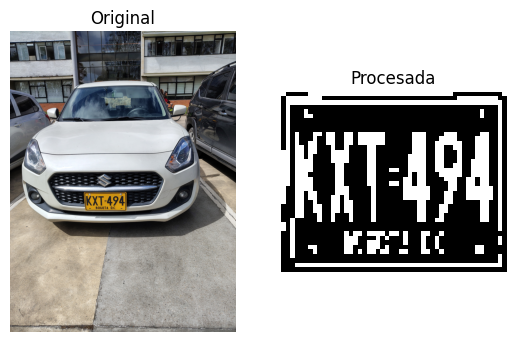

Vector bits (primeros 64): [0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1]


In [92]:
import matplotlib.pyplot as plt

fila = df.iloc[160]
orig = cv2.cvtColor(cv2.imread(fila.original), cv2.COLOR_BGR2RGB)
proc = cv2.imread(fila.procesada, cv2.IMREAD_GRAYSCALE)
bits = np.load(fila.bits)                 # (1350,)

plt.subplot(1, 2, 1); plt.imshow(orig); plt.title("Original");  plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(proc, cmap="gray"); plt.title("Procesada"); plt.axis("off")
plt.show()

print("Vector bits (primeros 64):", bits[:64])

In [102]:
import cv2, numpy as np, re, easyocr, matplotlib.pyplot as plt

reader = easyocr.Reader(['en'], gpu=False)

# ── mapas de confusión ──────────────────────────────────────────────
# dígito detectado donde debería ir letra
DIG2LET = {'0':'O', '1':'I', '2':'Z', '5':'S', '6':'G', '8':'B'}
# letra detectada donde debería ir dígito
LET2DIG = {'O':'0', 'Q':'0', 'D':'0',
           'I':'1', 'L':'1',
           'Z':'2',
           'S':'5', 'E':'5',
           'G':'6',
           'B':'8',
           'P':'9'}

def corrige_patron(text):
    """
    Convierte "R1U6S8" → "RLU658"
    Devuelve '' si tras la corrección no queda patrón ABC123 válido.
    """
    if len(text) < 6:
        return ''
    cand = list(text[:6])

    # primeras 3 posiciones = letras
    for i in range(3):
        if cand[i].isdigit() and cand[i] in DIG2LET:
            cand[i] = DIG2LET[cand[i]]

    # últimas 3 posiciones = dígitos
    for i in range(3, 6):
        if cand[i].isalpha() and cand[i] in LET2DIG:
            cand[i] = LET2DIG[cand[i]]

    out = ''.join(cand)
    return out if re.fullmatch(r'[A-Z]{3}[0-9]{3}', out) else ''


def ocr_placa_easy(path_proc, debug=False):
    img = cv2.imread(str(path_proc), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return ""

    # 1️⃣  Suavizado bilateral
    img = cv2.bilateralFilter(img, 5, 15, 15)

    # 2️⃣  Invertir si fondo claro
    if np.mean(img) > 127:
        img = 255 - img

    # 3️⃣  Recorte fijo (tus valores)
    H, W0 = img.shape
    rec = img[int(0.19*H): int(0.78*H), int(0.05*W0): int(0.97*W0)]
    h, W = rec.shape  # W para el escalado

    # 4️⃣  Escalar (12× o hasta llegar a 600 px)
    scale = max(5, int(600 / W))
    big = cv2.resize(rec, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    # 5️⃣  Umbral Otsu
    _, bw = cv2.threshold(big, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 6️⃣  OCR
    raw = ''.join(reader.readtext(bw, detail=0, paragraph=False,
                                  allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))
    clean = re.sub('[^A-Z0-9]', '', raw.upper())

    # 7️⃣  Intenta ABC123 directo
    m = re.search(r'[A-Z]{3}[0-9]{3}', clean)
    if m:
        text = m.group(0)
    else:
        # 8️⃣  Aplica corrección posición‑específica
        text = corrige_patron(clean)

    if debug:
        plt.imshow(bw, cmap='gray')
        plt.title(f"raw: {clean}  →  final: {text}")
        plt.axis('off')
        plt.show()

    return text



Using CPU. Note: This module is much faster with a GPU.


In [104]:
import pandas as pd
from tqdm.auto import tqdm

df = pd.read_csv("dataset/registro.csv")

n_ok = 0
ocr_col = []
for ruta in tqdm(df.procesada):
    txt = ocr_placa_easy(ruta, False)
    if txt: n_ok += 1
    ocr_col.append(txt)

df["ocr_text"] = ocr_col
df.to_csv("dataset/registro.csv", index=False)
print(f"Reconocidas {n_ok} de {len(df)} placas.")


  0%|          | 0/182 [00:00<?, ?it/s]/home/jpalaciosch/Documents/UNAL/Septimo semestre/Comunicaciones/Proyecto final/venv/lib64/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 182/182 [06:14<00:00,  2.06s/it]

Reconocidas 54 de 182 placas.


In [1]:
# ============================  PREPARACIÓN  ============================ #
import pandas as pd
import numpy as np
from pathlib import Path
from base64 import b64encode
from PIL import Image
import io, json

# Rutas
SRC_CSV  = "dataset/registro.csv"          # CSV con paths
DST_CSV  = "dataset/autos_embebido.csv"       # CSV de salida

# =========================  FUNCIONES AUXILIARES  ====================== #
def img_to_base64(path: Path) -> str:
    """Lee una imagen y devuelve un string base‑64 (sin saltos de línea)."""
    with path.open("rb") as f:
        return b64encode(f.read()).decode("ascii")

def bits_to_list(path: Path) -> list:
    """Carga el .npy y lo convierte a lista de ints (0/1)."""
    return np.load(path).astype(int).tolist()

# =====================  CARGAR Y CONVERTIR EL CSV  ===================== #
df = pd.read_csv(SRC_CSV)

# Aplicar conversiones
df["original"]  = df["original"].apply(lambda p: img_to_base64(Path(p)))
df["procesada"] = df["procesada"].apply(lambda p: img_to_base64(Path(p)))
df["bits"]      = df["bits"].apply(lambda p: bits_to_list(Path(p)))

# (Opcional) Si prefieres que la lista de bits sea un JSON string:
# df["bits"] = df["bits"].apply(json.dumps)

# =========================  GUARDAR EL NUEVO CSV  ====================== #
df.to_csv(DST_CSV, index=False)
print("✅ Listo:", DST_CSV)


✅ Listo: dataset/autos_embebido.csv


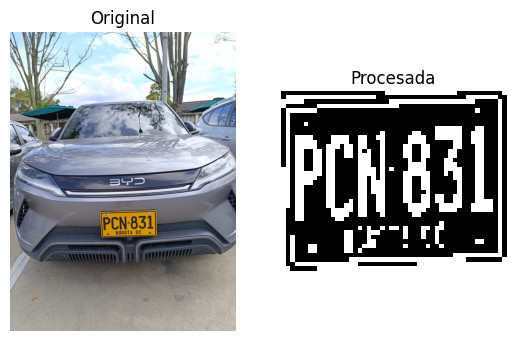

Vector bits: [1 1 1 ... 0 0 0]
Longitud total bits: 2000
Texto OCR: PCH831


In [12]:
import pandas as pd, numpy as np, cv2, base64, io, json
import matplotlib.pyplot as plt

# --- 1. Cargar el CSV con datos embebidos ---
df = pd.read_csv("dataset/autos_embebido.csv") 

# --- 2. Funciones de decodificación ------------------------------------ #
def b64_to_cv2_rgb(b64_str: str):
    """Convierte una imagen base‑64 a un array RGB listo para plt.imshow."""
    buf = base64.b64decode(b64_str)
    arr = np.frombuffer(buf, np.uint8)
    bgr = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def decode_bits(bits_cell):
    """
    Convierte la columna 'bits' a un np.ndarray.
    - Si la celda ya es lista → np.array
    - Si viene como JSON string  → json.loads + np.array
    """
    if isinstance(bits_cell, list):
        return np.array(bits_cell, dtype=int)
    else:
        return np.array(json.loads(bits_cell), dtype=int)

# --- 3. Seleccionar y mostrar una fila --------------------------------- #
fila = df.iloc[4]                     
orig = b64_to_cv2_rgb(fila.original)     
proc = b64_to_cv2_rgb(fila.procesada)   
bits = decode_bits(fila.bits)           

plt.subplot(1, 2, 1); plt.imshow(orig); plt.title("Original");  plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(proc, cmap="gray"); plt.title("Procesada"); plt.axis("off")
plt.show()

print("Vector bits:", bits)
print("Longitud total bits:", bits.size)
print("Texto OCR:", fila.ocr_text)


In [10]:
df['bits']

0      [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...
1      [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
                             ...                        
177    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
178    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
179    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
180    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
181    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: bits, Length: 182, dtype: object